In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import fnmatch
import csv
import pickle
import warnings
warnings.filterwarnings('ignore')
from copy import copy



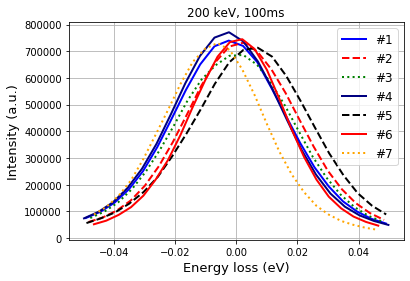

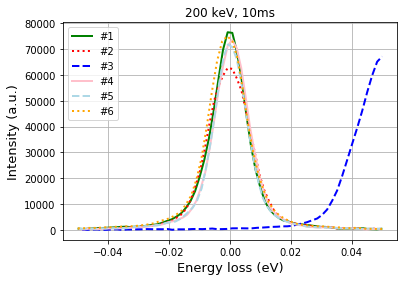


 ************************ Data files have been prepared ***************************** 

Seed number for this set is: 51


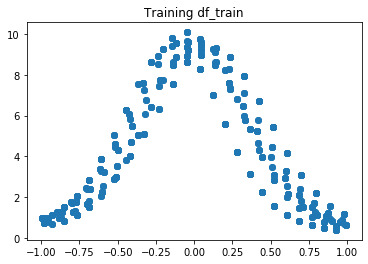

In [5]:
%run EELS-ZLP-Mar.py
%run Functions.ipynb

In [6]:
nbins = 20
x_train10, y_train10, x_val, y_val = prepare_mix_data(10)
df_train10, cuts1_t, cuts2_t = ewd(x_train10, y_train10)
x_train100, y_train100, x_val, y_val = prepare_mix_data(100)
df_train100, cuts1_t, cuts2_t = ewd(x_train100, y_train100)

In [52]:
%run Evaluate_pseudodata.ipynb

[0.1022835  0.1022835  0.1022835  ... 0.06688296 0.06688296 0.06688296]


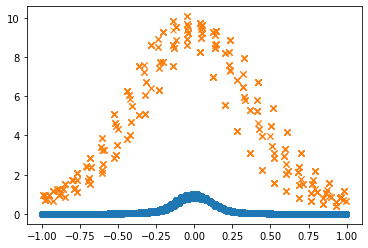

In [27]:
from lmfit import Model

x_10 = np.squeeze(np.array(df_train10[:,0]))
x_100 = np.squeeze(np.array(df_train100[:,0]))

y_10 = np.squeeze(np.array(df_train10[:,1]))
y_100 = np.squeeze(np.array(df_train100[:,1]))

plt.plot(x_10, y_10, 'o')
plt.plot(x_100, y_100, 'x')

plt.show()


In [42]:
def gaussian(x, amp, cen, std):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return (amp) * np.exp(-(x-cen)**2 / (2*std**2))

gmodel = Model(gaussian)

result_10 = gmodel.fit(y_10, x=x_10, amp=1, cen=0, std=0.4)
result_100 = gmodel.fit(y_100, x=x_100, amp=1, cen=0, std=0.5)
#print(result_10.fit_report(),result_100.fit_report())

### ZLP for 10 ms

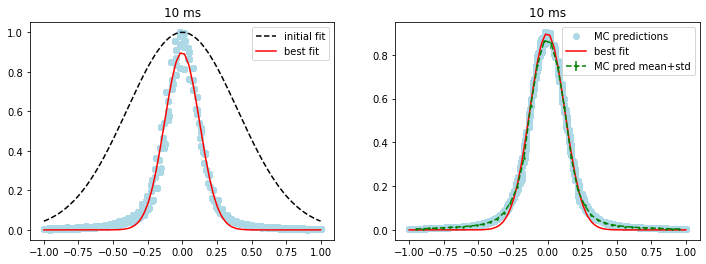

In [87]:
fig = plt.gcf()
plt.subplot(121)
fig.set_size_inches(12, 4)
plt.plot(x_10, y_10, 'o', color='lightblue')
#plt.plot(pseudo_x, pseudo_pred, 'o', label='MC predictions', color='lightblue')
plt.plot(x_10, result_10.init_fit, 'k--', label='initial fit')
plt.plot(x_10, result_10.best_fit, 'r-', label='best fit')

plt.title('10 ms')
plt.legend(loc='best')

plt.subplot(122)
plt.plot(pseudo_x, pseudo_pred, 'o', label='MC predictions', color='lightblue')
plt.errorbar(np.linspace(-0.95,0.95,40), pseudo_mean, yerr = pseudo_std, marker='.',linestyle='--', color='green', 
         mec='green', ms=3, label='MC pred mean+std')
plt.plot(x_10, result_10.best_fit, 'r-', label='best fit')

plt.title('10 ms')
plt.legend(loc='best')



In [35]:
#result_10

## 100 ms

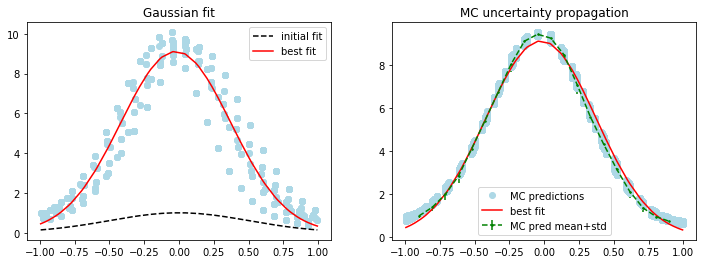

In [86]:
fig = plt.gcf()
plt.subplot(121)
fig.set_size_inches(12, 4)
plt.plot(x_100, y_100, 'o', color='lightblue')
#plt.plot(pseudo_x, pseudo_pred, 'o', label='MC predictions', color='lightblue')
plt.plot(x_100, result_100.init_fit, 'k--', label='initial fit')
plt.plot(x_100, result_100.best_fit, 'r-', label='best fit')

plt.title('Gaussian fit')
plt.legend(loc='best')

plt.subplot(122)
plt.plot(pseudo100_x, pseudo100_pred, 'o', label='MC predictions', color='lightblue')
plt.errorbar(np.linspace(-0.9,0.9,20), pseudo100_mean, yerr = pseudo100_std, marker='.',linestyle='--', color='green', 
         mec='green', ms=3, label='MC pred mean+std')

plt.plot(x_100, result_100.best_fit, 'r-', label='best fit')

plt.title('MC uncertainty propagation')
plt.legend(loc='best')
plt.show()


## Time variations

In [14]:
def fit_two_gaussians(gaus0, gaus1, T0, T1):
    """"Find the dependency parameters of two Gaussians with different exposure times
    in the following form: 
    
    f (dE, t_exp) = N_E * (T1/T0)**(m) * exp(-(dE)**2 / (2*std0**2)(T1/T0)**(k) )
    
            N_E = normalization constant for gaus0
            (T1/T0) = t(gauss1)/t(gauss0) with t=exposure time
            
    returns: m, k"""
    # gaus0 and gaus1 are result_[ms] (eg result_10 and result_100)
    amp0 = gaus0.params['amp'].value
    amp1 = gaus1.params['amp'].value
    
    std0 = gaus0.params['std'].value
    std1 = gaus1.params['std'].value
    
    cen0 = gaus0.params['cen'].value
    cen1 = gaus1.params['cen'].value
    
    m = math.log((T1/T0),(amp1/amp0))
    k = math.log((T1/T0),(std1**2 / std0**2))
    
    return m, k
    
m, k = fit_two_gaussians(result_10, result_100, 10, 100)
print(m,k)
    

1.0036132160069609 0.9980342920346926


In [15]:
def predict_gaussian(x, gaus0, T0, T1, m, k):
    amp0 = gaus0.params['amp'].value
    std0 = gaus0.params['std'].value
    cen0 = gaus0.params['cen'].value
    exponent = np.exp((-(x-cen0)**2) / ( 2*std0**2 * (T1/T0)**k))
    new_gauss = amp0 * (T1/T0)**m * exponent 
    return new_gauss
    

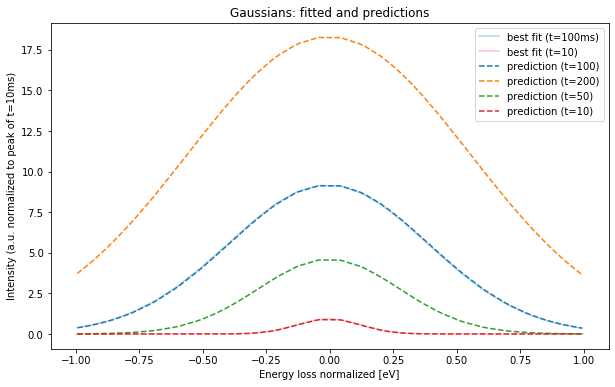

In [16]:
fig = plt.gcf()
m, k = fit_two_gaussians(result_10, result_100, 10, 100)

function_100 = predict_gaussian(x_100, gaus0=result_10, T0=10, T1=100, m=0.99639, k=1.00174)
function_200 = predict_gaussian(x_100, gaus0=result_10, T0=10, T1=200, m=0.99639, k=1.00174)
function_50 = predict_gaussian(x_100, gaus0=result_10, T0=10, T1=50, m=0.99639, k=1.00174)
function_10 = predict_gaussian(x_100, gaus0=result_10, T0=10, T1=10, m=0.99639, k=1.00174)
fig.set_size_inches(10,6)
plt.plot(x_100, result_100.best_fit, linestyle='solid', color='lightblue', label='best fit (t=100ms)')
plt.plot(x_10, result_10.best_fit, linestyle='solid', color='pink', label='best fit (t=10)')
plt.plot(x_100, function_100, linestyle='dashed', label='prediction (t=100)')
plt.plot(x_100, function_200, linestyle='dashed', label='prediction (t=200)')
plt.plot(x_100, function_50, linestyle='dashed', label='prediction (t=50)')
plt.plot(x_100, function_10, linestyle='dashed', label='prediction (t=10)')
plt.title('Gaussians: fitted and predictions')
plt.ylabel('Intensity (a.u. normalized to peak of t=10ms)')
plt.xlabel('Energy loss normalized [eV]')
plt.legend()
plt.show()